In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import KernelPCA, PCA
import warnings
warnings.filterwarnings("ignore")

In [2]:
umist = sio.loadmat('umist_cropped.mat')
dataset = umist['facedat']
data_lst = []
X=[]
y=[]
for i in range(20):
    person_imgs = dataset[0][i]
    person_imgs = np.transpose(person_imgs, (2,0,1))
    data_lst.append(person_imgs)
    for img in person_imgs:
        X.append(img)
        y.append(i)


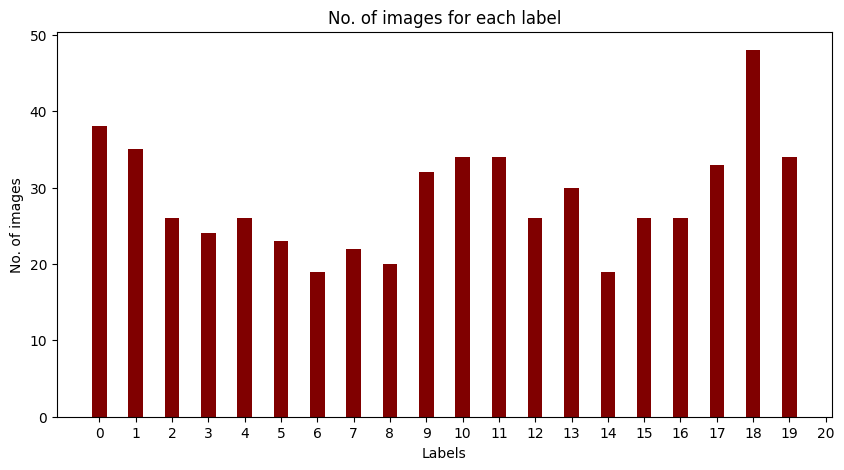

In [3]:
from collections import Counter

def plot_labels(dataset):
    data = Counter(dataset)
    courses = list(data.keys())
    values = list(data.values())
     
    fig = plt.figure(figsize = (10, 5))
    
    # creating the bar plot
    plt.bar(courses, values, color ='maroon', 
            width = 0.4)
    
    plt.xlabel("Labels")
    plt.ylabel("No. of images")
    plt.title("No. of images for each label")
    plt.xticks(range(21))
    plt.show()
plot_labels(y)

In [4]:
import tensorflow as tf
import keras
import random

def random_augmentation(images):
    length = len(images)-1
    ran = random.randint(0, length)
    ran_image = images[ran]
    ran_delta = random_number = random.uniform(-0.4, 0.4)
    result = tf.image.adjust_brightness(ran_image, ran_delta)
    #plt.imshow(images[ran])
    #plt.show()
    #plt.imshow(result)
    #plt.show()
    return result

In [5]:
target_num = 50
X_add = []
y_add = []
for idx, j in enumerate(data_lst):
    num_of_images = len(j)
    while num_of_images < target_num:
        new_img = random_augmentation(j)
        #X_add = np.append(X_add, new_img)
        X_add.append(new_img.numpy())
        #X_add.append(new_img)
        y_add.append(idx)
        num_of_images+=1

X.extend(X_add)
y.extend(y_add)

In [7]:
for h in range(5):
    print(y.count(h))

50
50
50
50
50


In [10]:
np_array = np.array(X)
X = []
for i in np_array:
    i = i.flatten()
    X.append(i)

y = np.array(y)

from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()
X = trans.fit_transform(X)

In [31]:
from sklearn.decomposition import PCA
pca = PCA(0.99)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(345, 215)


In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=53)
train_n_valid_idx, test_idx = next(strat_split.split(X, y))
X_train_n_valid = X[train_n_valid_idx]
y_train_n_valid = y[train_n_valid_idx]
X_test = X[test_idx]
y_test = y[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=53)
train_idx, valid_idx = next(strat_split.split(X_train_n_valid, y_train_n_valid))
X_train = X_train_n_valid[train_idx]
y_train = y_train_n_valid[train_idx]
X_valid = X_train_n_valid[valid_idx]
y_valid = y_train_n_valid[valid_idx]

In [12]:
print(X.shape)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1000, 10304)
(600, 10304)
(200, 10304)
(200, 10304)


In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=40, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
X_valid_tsne = tsne.fit_transform(X_valid)
X_test_tsne = tsne.fit_transform(X_test)

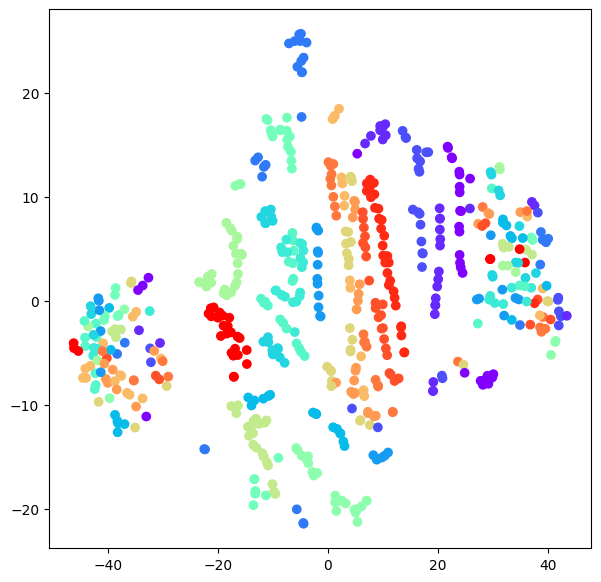

In [14]:
plt.figure(figsize=(7,7))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='rainbow')
plt.show()

In [15]:
from sklearn.mixture import GaussianMixture
# Calculate BIC.
max_cluster = 30

cluster_range = range(1,max_cluster)

def compute_bic(X):
    all_bic_values = []
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    for ctype in covariance_types:
        bic_values=[]
        for i in cluster_range:
            gmm = GaussianMixture(n_components=i, covariance_type=ctype)
            gmm.fit(X)
            bic_values.append(gmm.bic(X))
        all_bic_values.append(bic_values)
    return all_bic_values

bic = compute_bic(X_train_tsne)

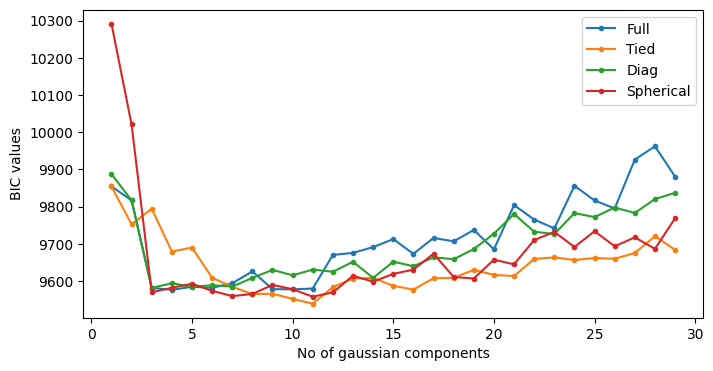

In [16]:
plt.figure(figsize=(8,4))
plt.plot(cluster_range, bic[0], marker = '.', label ='Full')
plt.plot(cluster_range, bic[1], marker = '.', label ='Tied')
plt.plot(cluster_range, bic[2], marker = '.', label ='Diag')
plt.plot(cluster_range, bic[3], marker = '.', label ='Spherical')
plt.xlabel("No of gaussian components")
plt.ylabel("BIC values")
plt.legend()
plt.show()

In [17]:
print(f'The minimum BIC by Full : {np.min(bic[0])}')
print(f'The minimum BIC by Tied : {np.min(bic[1])}')
print(f'The minimum BIC by Diag : {np.min(bic[2])}')
print(f'The minimum BIC by Spherical : {np.min(bic[3])}')

The minimum BIC by Full : 9576.562516043923
The minimum BIC by Tied : 9539.397093994183
The minimum BIC by Diag : 9581.999489648739
The minimum BIC by Spherical : 9558.10308311209


In [18]:
con_type_index = np.argmin([np.min(bic[0]),np.min(bic[1]),np.min(bic[2]),np.min(bic[3])])
con_type = "full"
if con_type_index == 0:
    con_type = "full"
elif con_type_index == 1:
    con_type = "tied"
elif con_type_index == 2:
    con_type = "diag"
else:
    con_type = "spherical"

In [19]:
k = np.argmin(bic[con_type_index])+1
print(f'The best covariance type: {con_type}')
print(f'The optimal number of clusters: {k}')

The best covariance type: tied
The optimal number of clusters: 11


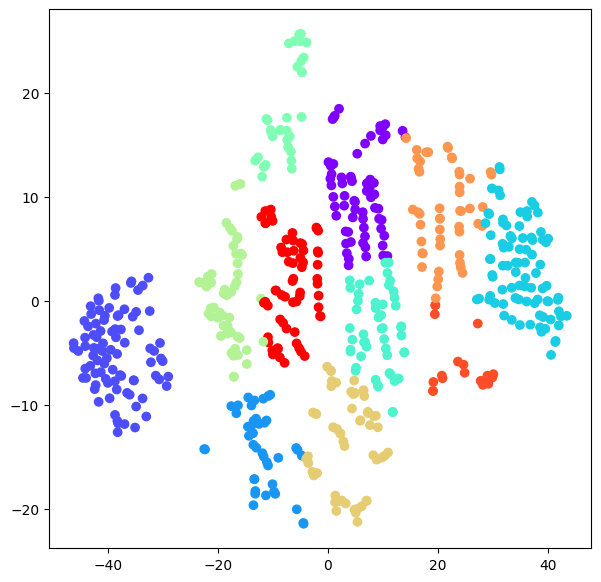

In [20]:
gmm = GaussianMixture(n_components=k, covariance_type=con_type)
gmm.fit(X_train_tsne)

labels_hard = gmm.predict(X_train_tsne)
plt.figure(figsize=(7,7))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_hard, cmap='rainbow')
plt.show()

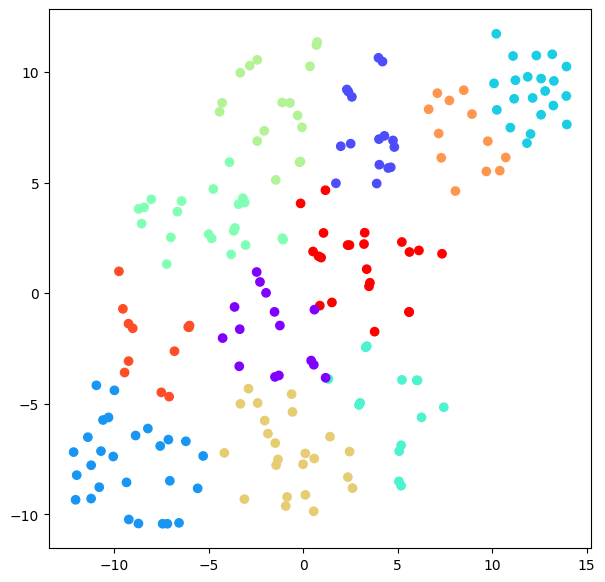

In [21]:
gmm = GaussianMixture(n_components=k, covariance_type=con_type)
gmm.fit(X_test_tsne)

labels_hard = gmm.predict(X_test_tsne)
plt.figure(figsize=(7,7))
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], c=labels_hard, cmap='rainbow')
plt.show()

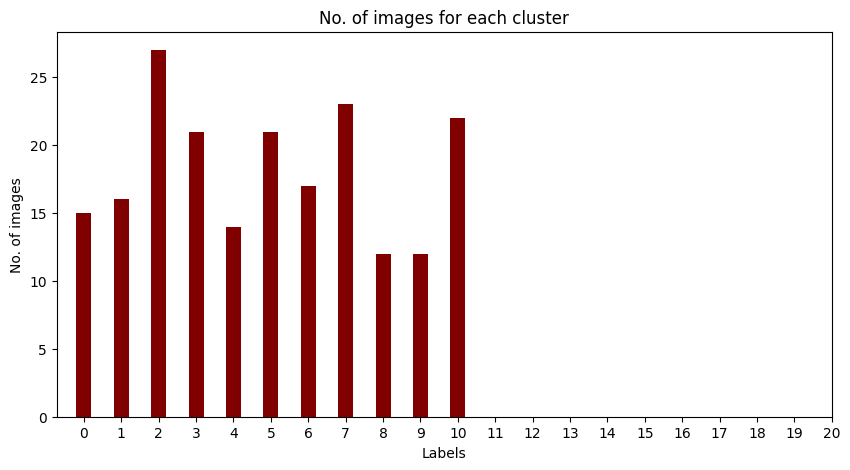

In [22]:
def plot_labels(dataset):
    data = Counter(dataset)
    courses = list(data.keys())
    values = list(data.values())
     
    fig = plt.figure(figsize = (10, 5))
    
    # creating the bar plot
    plt.bar(courses, values, color ='maroon', 
            width = 0.4)
    
    plt.xlabel("Labels")
    plt.ylabel("No. of images")
    plt.title("No. of images for each cluster")
    plt.xticks(range(21))
    plt.show()
plot_labels(labels_hard)

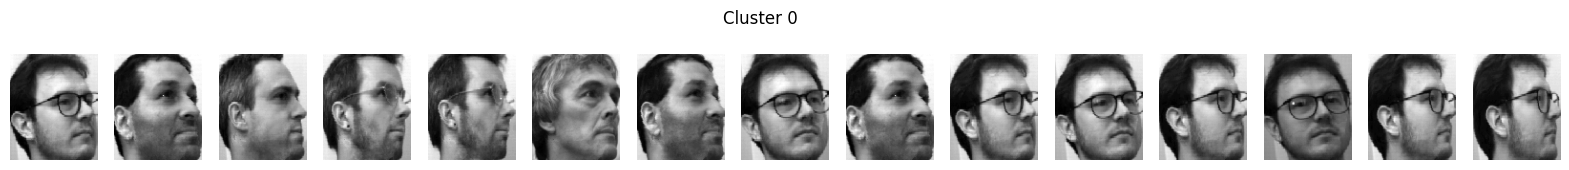

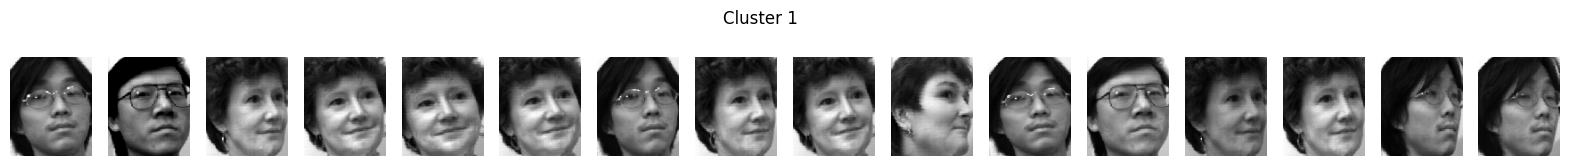

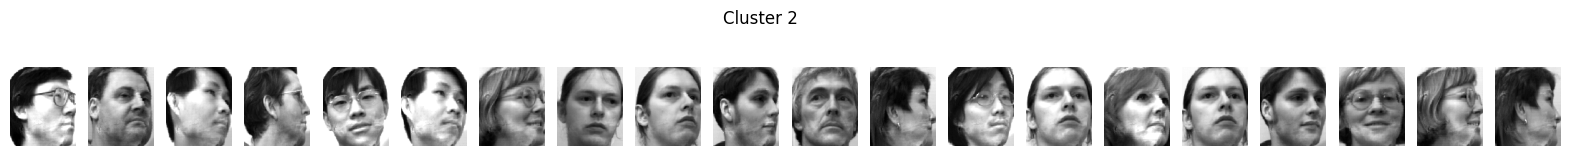

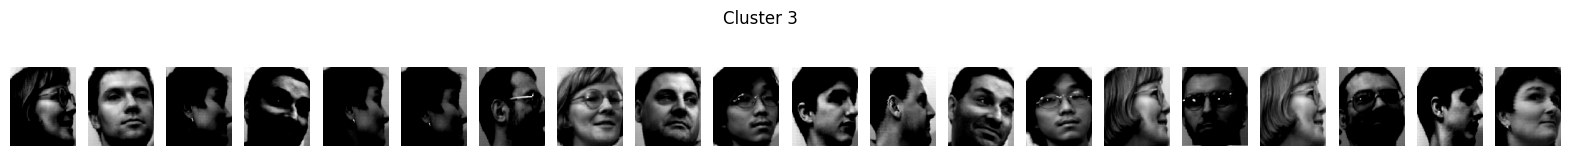

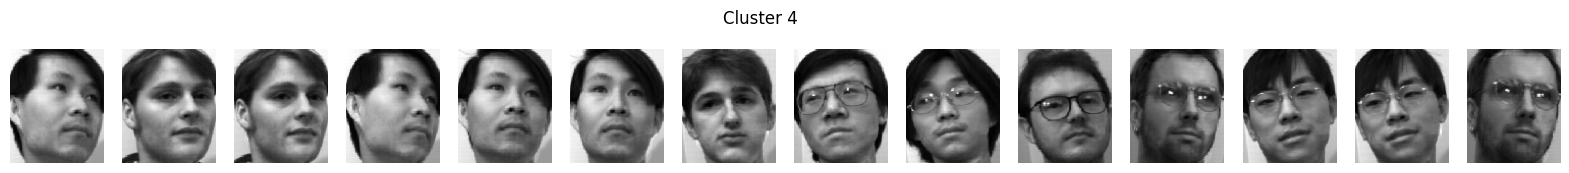

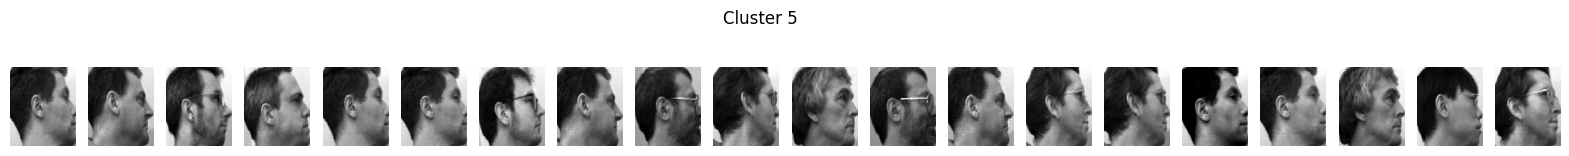

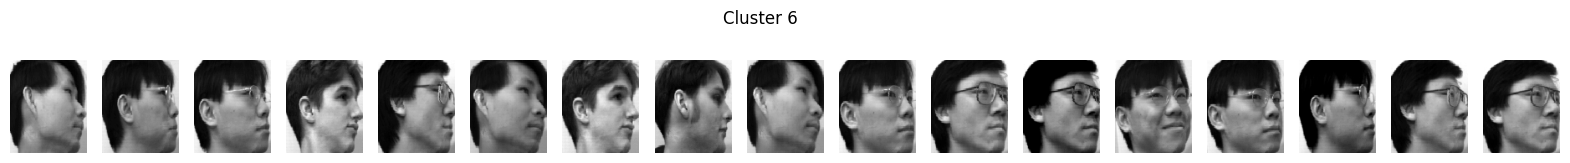

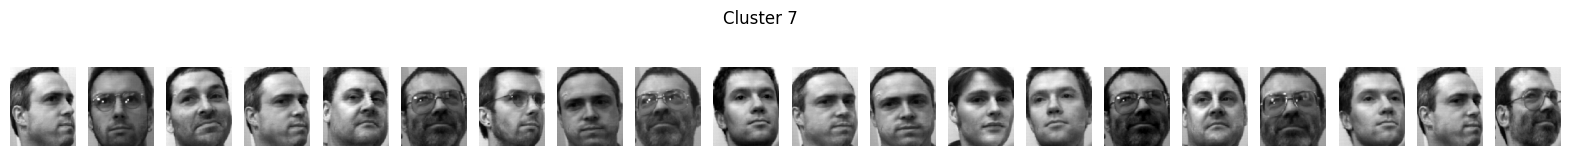

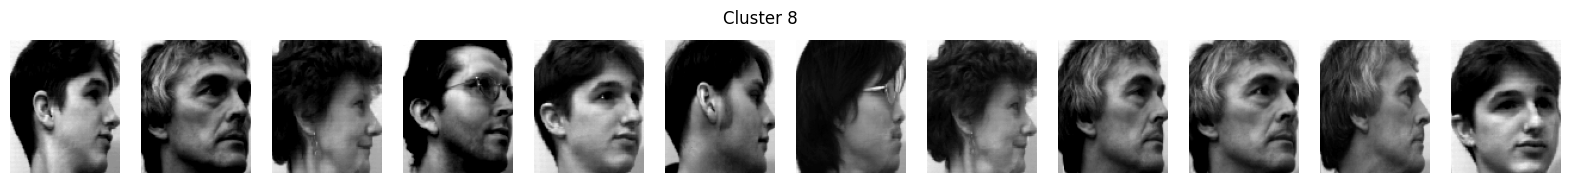

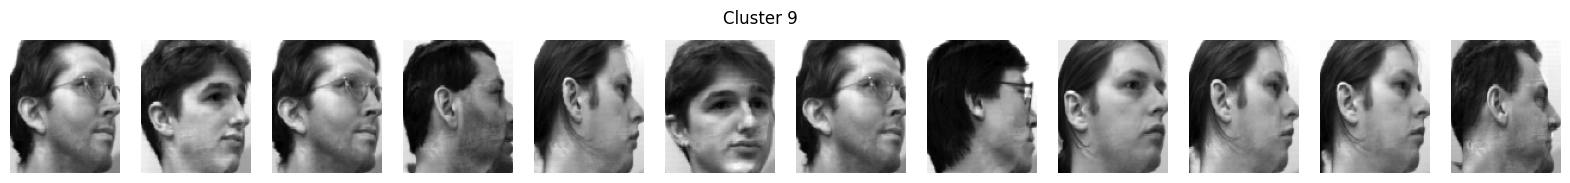

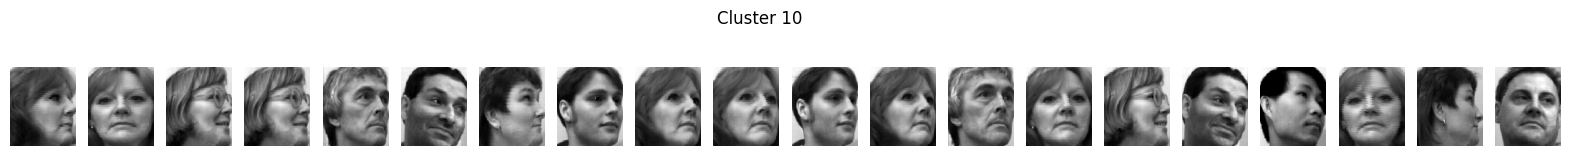

In [23]:
# Plot the first 10 images in each cluster
for cluster_id in range(21):
    # Get the indices of images in the current cluster
    cluster_indices = np.where(labels_hard == cluster_id)[0]
    
    # Determine the number of images to plot
    num_images = min(20, len(cluster_indices))
    
    if num_images > 0:
        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        
        for i in range(num_images):
            # Get the image index
            image_index = cluster_indices[i]
            
            # Get the image data
            image_data = X_test[image_index]
            
            # Reshape the image data
            image_data = image_data.reshape(112, 92)
            
            # Plot the image
            if num_images == 1:
                axes.imshow(image_data, cmap='gray')
                axes.axis('off')
            else:
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
        plt.suptitle(f"Cluster {cluster_id}")
        plt.show()